# teleporting

In [1]:
#prereq
%pip -q install qiskit numpy qiskit-aer matplotlib pylatexenc

Note: you may need to restart the kernel to use updated packages.


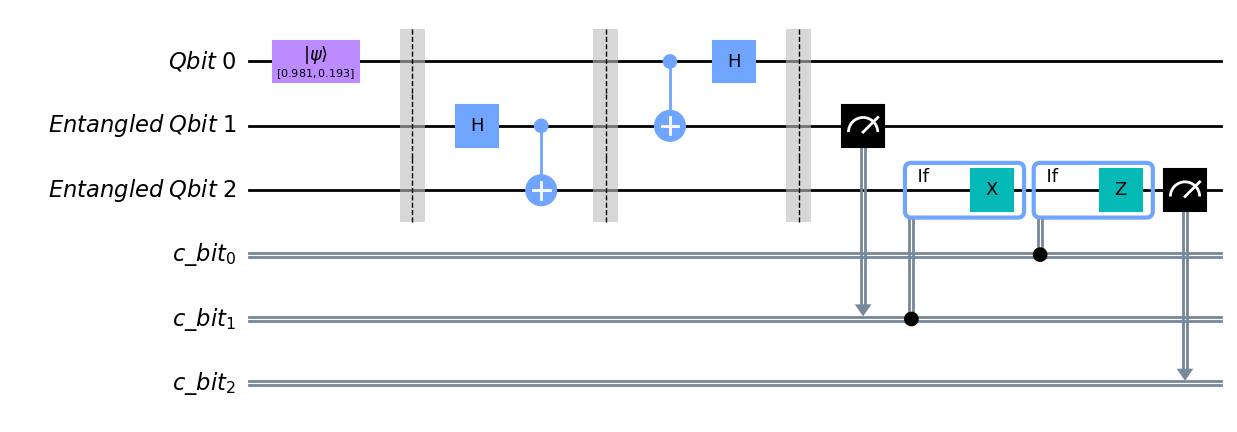


Qbit 0: |ψ⟩ (0.9813, 0.1926)
Qbit 2: |ψ⟩ (0.9813, 0.1923)
Bloch Vector: (0.3774, 0.0000, 0.9260)



In [30]:
import random
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.result import marginal_counts
from qiskit.tools.visualization import plot_histogram, plot_bloch_vector

# Creating quantum registers
def create_registers():
    q0 = QuantumRegister(1, 'Qbit 0')
    entangled_q1 = \
        QuantumRegister(1, 'Entangled Qbit 1')
    entangled_q2 = QuantumRegister(1, 'Entangled Qbit 2')
    classical_bit = ClassicalRegister(3, 'c_bit')
    circ = QuantumCircuit(q0, entangled_q1, entangled_q2, classical_bit)
    return circ

# Randomize the amplitudes
def generate_amplitudes():
    qbit_0_alpha = np.sqrt(random.uniform(0, 1))
    qbit_0_beta = np.sqrt(1 - qbit_0_alpha**2) # sums must equals to 1
    return qbit_0_alpha, qbit_0_beta

def add_gates(circ, qbit_0_alpha, qbit_0_beta):
    circ.initialize([qbit_0_alpha, qbit_0_beta], 0)
    circ.barrier()
    circ.h(1)
    circ.cnot(1, 2)
    circ.barrier()
    circ.cnot(0, 1)
    circ.h(0)
    circ.barrier()
    #circ.measure(0, 0)
    circ.measure(1, 1)
    with circ.if_test((1, 1)):
        circ.x(2)
    with circ.if_test((0, 1)):
        circ.z(2)
    circ.measure(2, 2)
    return circ

def amplitude_to_bloch(alpha, beta):
    x = 2 * np.real(beta * np.conj(alpha))
    y = 2 * np.imag(beta * np.conj(alpha))
    z = np.abs(alpha) ** 2 - np.abs(beta) ** 2
    return x, y, z

# Create the circuit
qbit_0_alpha, qbit_0_beta = generate_amplitudes()
circ = create_registers()
circ = add_gates(circ, qbit_0_alpha, qbit_0_beta)
display(circ.draw('mpl', cregbundle=False))

# Execute the job on a simulator
device = Aer.get_backend("qasm_simulator")
shots = 100000
job = device.run(circ, shots=shots)

# Getting the results
result = job.result()
counts = result.get_counts(circ)
counts_m = marginal_counts(counts, [2])
number_of_0s = counts_m.get('0') 
number_of_1s = counts_m.get('1') 
Qbit_2_alpha = np.sqrt(number_of_0s / shots)
Qbit_2_beta = np.sqrt(number_of_1s / shots)
x, y, z = amplitude_to_bloch(Qbit_2_alpha, Qbit_2_beta)

# Showing the results
print("\nQbit 0: |\u03C8\u27E9 ({:.4f}, {:.4f})".format(qbit_0_alpha, qbit_0_beta))
print("Qbit 2: |\u03C8\u27E9 ({:.4f}, {:.4f})".format(Qbit_2_alpha, Qbit_2_beta))
print(f"Bloch Vector: ({x:.4f}, {y:.4f}, {z:.4f})\n")

# Saving the results
bloch_plot = plot_bloch_vector([x, y, z], title="Bloch Vector Plot")
bloch_plot.savefig("bloch_plot.png")

histogram = plot_histogram(counts, title="Histogram Plot")
histogram.savefig("histogram.png")

# Saving the circuit as an image file
circ.draw('mpl', cregbundle=False).savefig('circuit_diagram.png')